# Merge data and filter

In [1]:
import numpy as np
import pandas as pd
# import dask.dataframe as dd
from urllib.parse import urlparse

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from scipy.sparse import load_npz

from tqdm import tqdm

## Load Data

In [2]:
# domain_index = pd.read_csv('../02_data/data_archive/raphaela/lasser/domain_pc1.csv')
# chat_index = np.load('../02_data/telegram/telegram/chat_index.npy')
# urls_sample = pd.read_csv('../02_data/url_sample_with_titles.csv')

In [3]:
domain_index = pd.read_csv('../02_data/domain_pc1.csv')
chat_index = np.load('../02_data/chat_index.npy')
# urls_sample = pd.read_csv('../02_data/url_sample_with_titles.csv')

In [4]:
urls = pd.read_parquet('../02_data/url.data.parquet', engine = 'fastparquet') # , engine='pyarrow'

In [5]:
chat_url_shares = load_npz('../02_data/chat_url_shares.npz')

In [6]:
print("Chat Index Shape:", chat_index.shape)
print(urls.head())

Chat Index Shape: (27592,)
   index                                                url  \
0      0    https://odysee.com/@jermwarfare:2/The-Baileys:8   
1      1  https://drsambailey.com/its-elementary-my-dear...   
2      2  https://drsambailey.com/why-nobody-had-caught-...   
3      3  https://live.childrenshealthdefense.org/shows/...   
4      4  https://jonrappoport.substack.com/p/the-millio...   

                       domain  messages  chats  avalanches  \
0                  odysee.com        11      9          10   
1             drsambailey.com        18     14          13   
2             drsambailey.com       104     71          59   
3  childrenshealthdefense.org        31     24          18   
4                substack.com        24     20          14   

   mean_avalanche_size  top_avalanche_size  virality  top_shares_1h  \
0             1.100000                   2  0.327777              2   
1             1.384615                   4  0.323942              4   
2       

### Jana Lasser PCA results (Groundtruth)

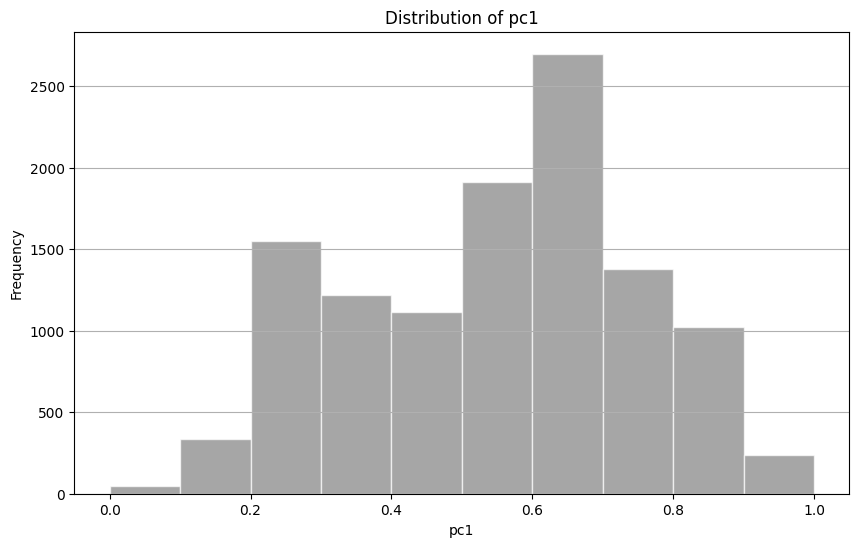

Top 5 rows with the highest pc1 scores:
                 domain       pc1
0           reuters.com  1.000000
1            apnews.com  0.998049
2  charitynavigator.org  0.985752
3          rollcall.com  0.982851
4    smithsonianmag.com  0.971184

Bottom 5 rows with the lowest pc1 scores:
                domain       pc1
11519  naturalnews.com  0.000000
11518    worldtruth.tv  0.017644
11517    davidicke.com  0.041614
11516    pandemic.news  0.043817
11513        rense.com  0.044752


In [7]:
# Plot the distribution of the 'pc1' column
plt.figure(figsize=(10, 6))
plt.hist(domain_index['pc1'], color='grey', alpha=0.7, edgecolor='white')
plt.title('Distribution of pc1')
plt.xlabel('pc1')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.savefig('../03_plots/hist_pc1.png')
plt.show()

# Show the row with the highest 'pc1' score
highest_scores = domain_index.nlargest(5, 'pc1')
print("Top 5 rows with the highest pc1 scores:")
print(highest_scores)

# Show the 5 rows with the lowest 'pc1' scores
lowest_scores = domain_index.nsmallest(5, 'pc1')
print("\nBottom 5 rows with the lowest pc1 scores:")
print(lowest_scores)

highest_scores = domain_index.nlargest(5, 'pc1')

# Show the 5 rows with the lowest 'pc1' scores
lowest_scores = domain_index.nsmallest(5, 'pc1')

# Combine both into a single table for export
highest_scores['Type'] = 'Highest'
lowest_scores['Type'] = 'Lowest'

combined_scores = pd.concat([highest_scores, lowest_scores])

# Export to CSV or Excel
combined_scores.to_csv('../03_plots/pc1_highest_lowest_scores.csv', index=False)

## Domain Index

In [8]:
# Step 2: Match domains with domain_index
urls = pd.merge(urls, domain_index, on='domain', how='inner')

# Display the first few rows of the merged DataFrame
print(urls.head())

# Drop rows where the domain was not found in domain_index
urls.dropna(subset=['pc1'], inplace=True)

   index                                                url  \
0      3  https://live.childrenshealthdefense.org/shows/...   
1     39  https://vernoncoleman.org/articles/vernon-cole...   
2     41  https://www.naturalblaze.com/2023/03/us-govern...   
3     42  https://expose-news.com/2023/05/26/rockefeller...   
4     43  https://rumble.com/vxv8s3-the-fluoride-decepti...   

                       domain  messages  chats  avalanches  \
0  childrenshealthdefense.org        31     24          18   
1           vernoncoleman.org        10      6           6   
2            naturalblaze.com        84     62          57   
3             expose-news.com       118     69          76   
4                  rumble.com       131     96          81   

   mean_avalanche_size  top_avalanche_size  virality  top_shares_1h  \
0             1.722222                   8  0.327384              8   
1             1.666667                   5  0.547723              4   
2             1.473684             

In [9]:
urls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18141615 entries, 0 to 18141614
Data columns (total 17 columns):
 #   Column               Dtype         
---  ------               -----         
 0   index                int64         
 1   url                  object        
 2   domain               object        
 3   messages             int64         
 4   chats                int64         
 5   avalanches           int64         
 6   mean_avalanche_size  float64       
 7   top_avalanche_size   int64         
 8   virality             float64       
 9   top_shares_1h        int64         
 10  top_shares_6h        int64         
 11  top_shares_1d        int64         
 12  top_shares_3d        int64         
 13  top_shares_14d       int64         
 14  first_share_date     datetime64[ns]
 15  final_share_date     datetime64[ns]
 16  pc1                  float64       
dtypes: datetime64[ns](2), float64(3), int64(10), object(2)
memory usage: 2.3+ GB


In [10]:
# Group by domain and count occurrences
domain_counts = urls['domain'].value_counts().reset_index()
domain_counts.columns = ['domain', 'frequency']

# Preview the result
print(domain_counts.head())

              domain  frequency
0        youtube.com    1709043
1         google.com     901224
2         rumble.com     456786
3  independent.co.uk     444269
4          4chan.org     395536


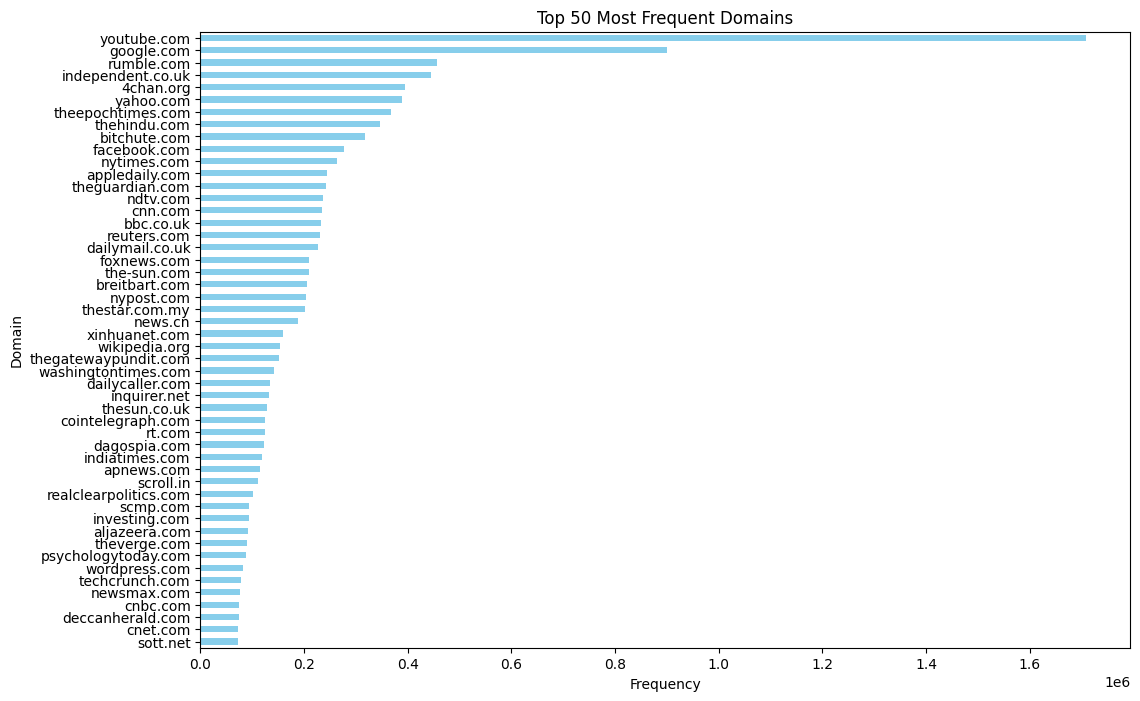

In [11]:
# Get the top 50 most frequent domains
top_domains = urls['domain'].value_counts().head(50)

# Plot the histogram
plt.figure(figsize=(12, 8))
top_domains.plot(kind='barh', color='skyblue')
plt.title('Top 50 Most Frequent Domains')
plt.xlabel('Frequency')
plt.ylabel('Domain')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

In [12]:
# Filter URLs that include "ift.tt"
ift_tt_urls = urls[urls['url'].str.contains("ift.tt", na=False)]

# Print a sample of the filtered URLs
print(ift_tt_urls.sample(5))  

             index                                                url  \
14353023  40922445  https://translate.google.com/translate?sl=sv&t...   
14348601  40914351  https://translate.google.com/translate?sl=sv&t...   
14351051  40919148  https://translate.google.com/translate?sl=sv&t...   
14360920  40935347  https://translate.google.com/translate?sl=sv&t...   
14342892  40902541  https://translate.google.com/translate?sl=sv&t...   

              domain  messages  chats  avalanches  mean_avalanche_size  \
14353023  google.com         1      1           1                  1.0   
14348601  google.com         1      1           1                  1.0   
14351051  google.com         1      1           1                  1.0   
14360920  google.com         1      1           1                  1.0   
14342892  google.com         1      1           1                  1.0   

          top_avalanche_size  virality  top_shares_1h  top_shares_6h  \
14353023                   1       1.0      

## Drop Social Media

In [13]:
social_media_domains = [
    'facebook.com', 'instagram.com', 'linkedin.com',
    'tiktok.com', 'snapchat.com',
    'youtube.com', 'youtu.be',  
    'twitter.com', 't.co', 't.me',
    'reddit.com', 'redd.it',
    'google.com', 'feedproxy.google.com', 'goo.gl',
    'bit.ly',
    # 'bit.ly', 'tinyurl.com', 'ow.ly', 'buff.ly', 'shorte.st', 'is.gd'
    'amzn.to', 'rumble.com', 'boards.4chan.org', '4chan.org',
    'telegra.ph', 'ift.tt' # ift.tt link compression 
]

# Function to check if a URL is from a social media site
def is_social_media(url):
    try:
        return any(domain in url for domain in social_media_domains)
    except:
        return None

tqdm.pandas()

# Filter out rows where the URL is from a social media site
urls_filtered = urls[~urls['domain'].apply(is_social_media)]

# Check the cleaned DataFrame
print(urls_filtered.head())

num_social_media = len(urls) - len(urls_filtered)
print(f"Number of URLs filtered out: {num_social_media}")

   index                                                url  \
0      3  https://live.childrenshealthdefense.org/shows/...   
1     39  https://vernoncoleman.org/articles/vernon-cole...   
2     41  https://www.naturalblaze.com/2023/03/us-govern...   
3     42  https://expose-news.com/2023/05/26/rockefeller...   
5     44  https://www.americaoutloud.com/fda-approves-ph...   

                       domain  messages  chats  avalanches  \
0  childrenshealthdefense.org        31     24          18   
1           vernoncoleman.org        10      6           6   
2            naturalblaze.com        84     62          57   
3             expose-news.com       118     69          76   
5          americaoutloud.com        14     12           7   

   mean_avalanche_size  top_avalanche_size  virality  top_shares_1h  \
0             1.722222                   8  0.327384              8   
1             1.666667                   5  0.547723              4   
2             1.473684             

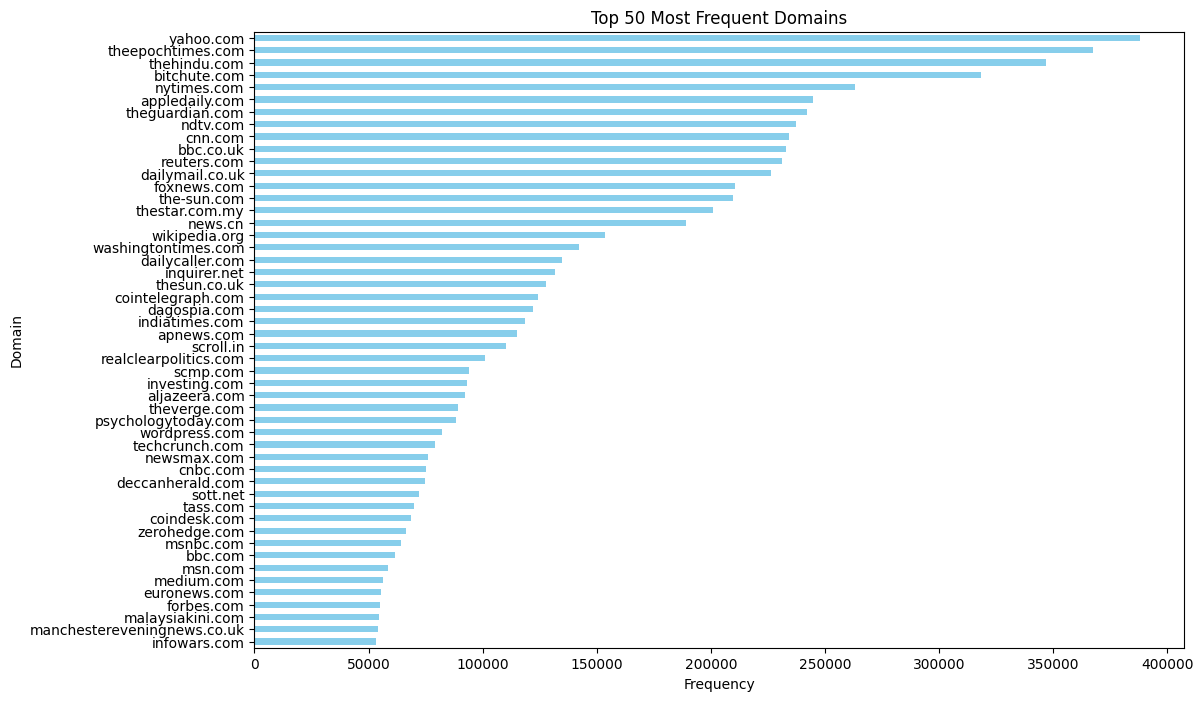

In [15]:
# Get the top 50 most frequent domains
top_domains = urls_filtered['domain'].value_counts().head(50)

# Plot the histogram
plt.figure(figsize=(12, 8))
top_domains.plot(kind='barh', color='skyblue')
plt.title('Top 50 Most Frequent Domains')
plt.xlabel('Frequency')
plt.ylabel('Domain')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.savefig('../03_plots/most_frequent_domains.png')
plt.show()

## Filter 1000 most forwarded url per domain

In [27]:
urls['rank'] = urls.groupby('domain')['top_shares_3d'].rank(ascending=False, method='first')

# Step 2: Filter to keep only the top 1000 rows per domain
top_1000_df = urls[urls['rank'] <= 1000]

# Step 3: Extract only the `url` column
top_1000_urls = top_1000_df[['url', 'index']]

print(top_1000_urls.head())
print(top_1000_urls.info())

                                                 url  index
1  https://vernoncoleman.org/articles/vernon-cole...     39
2  https://www.naturalblaze.com/2023/03/us-govern...     41
3  https://expose-news.com/2023/05/26/rockefeller...     42
5  https://www.americaoutloud.com/fda-approves-ph...     44
6  https://vernoncoleman.org/articles/passing-obs...     47
<class 'pandas.core.frame.DataFrame'>
Index: 1447779 entries, 1 to 18141608
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   url     1447779 non-null  object
 1   index   1447779 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 33.1+ MB
None


In [28]:
urls_filtered['rank'] = urls_filtered.groupby('domain')['top_shares_3d'].rank(ascending=False, method='first')

# Step 2: Filter to keep only the top 1000 rows per domain
top_1000_filtered_df = urls_filtered[urls_filtered['rank'] <= 1000]

# Step 3: Extract only the `url` column
top_1000_filtered = top_1000_filtered_df[['url', 'index']]
top_1000_filtered.info()

/tmp/ipykernel_70726/3372471996.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  urls_filtered['rank'] = urls_filtered.groupby('domain')['top_shares_3d'].rank(ascending=False, method='first')


<class 'pandas.core.frame.DataFrame'>
Index: 1352158 entries, 1 to 18141608
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   url     1352158 non-null  object
 1   index   1352158 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 30.9+ MB


## Datetime

In [18]:
urls['first_share_date'] = pd.to_datetime(urls['first_share_date'])
urls['final_share_date'] = pd.to_datetime(urls['final_share_date'])
urls['year'] = urls['first_share_date'].dt.year

## Export

In [19]:
import os

# Save the DataFrame as a CSV file in the '02_data' folder
folder_path = "../02_data/"
csv_path = os.path.join(folder_path, 'url_domains.csv')
urls.to_csv(csv_path, index=False)

In [29]:
csv_path = os.path.join(folder_path, 'top_1000_urls.csv')
top_1000_urls.to_csv(csv_path, index=False)

top_1000_filtered.to_csv('../02_data/top_1000_filtered.csv', index=False)

In [ ]:
# Compress and save the DataFrame as a .gz file
csv_gz_path = os.path.join(folder_path, 'top_1000_urls.csv.gz')
top_1000_urls.to_csv(csv_gz_path, index=False, compression='gzip')